In [657]:
import wave
import pyaudio
import matplotlib.pyplot as plt
import time
from scipy.io import wavfile
import numpy as np
import os
import shutil
from sklearn.decomposition import PCA

In [203]:
class PyAudioManager:
#     CHUNK = 1024
#     FORMAT = pyaudio.paInt16
#     CHANNELS = 2
#     RATE = 8000
#     RECORD_SECONDS = 5
    def __init__(self, CHUNK):
        self.CHUNK = CHUNK
    
    def record(self, 
               FORMAT, 
               CHANNELS,
               RATE, 
               RECORD_SECONDS, 
               filename='data/output/output.wav'):
        p = pyaudio.PyAudio()
        stream = p.open(format=FORMAT,
                        channels=CHANNELS,
                        rate=RATE,
                        input=True,
                        frames_per_buffer=self.CHUNK)
        print("Start recording...")
        frames = []
        for i in range(0, int(RATE / self.CHUNK * RECORD_SECONDS)):
            data = stream.read(self.CHUNK)
            frames.append(data)
        print("Finish recording")
        stream.stop_stream()
        stream.close()
        p.terminate()
        wf = wave.open(filename, 'wb')
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(p.get_sample_size(FORMAT))
        wf.setframerate(RATE)
        wf.writeframes(b''.join(frames))
        wf.close()
        
    def play(self, filename='data/output/output.wav'):
        wf = wave.open(filename, 'rb')
        p = pyaudio.PyAudio()
        stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                        channels=wf.getnchannels(),
                        rate=wf.getframerate(),
                        output=True)
        print("Start playing...")
        data = wf.readframes(self.CHUNK)
        while data != b'':
            stream.write(data)
            data = wf.readframes(self.CHUNK)
        print("Finish playing...")
        stream.stop_stream()
        stream.close()
        p.terminate()
        
    def get_wave(self, filename='data/output/output.wav'):
        sr, wave_arr = wavfile.read(filename)
        return sr, wave_arr
        
    def plot_wave(self, sr, wave_arr):
        sample_number = wave_arr.shape[0]
        total_time = int(sample_number / sr * 1000)
        time_series = np.linspace(0,total_time,sample_number)
        plt.figure(figsize=(8, 8))
        plt.plot(time_series, wave_arr)
        plt.title('Time*Amplitude')
        plt.xlabel('Time/ms')
        plt.ylabel('Amplitude/dB')
        

In [204]:
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 8000
RECORD_SECONDS = 3
pam = PyAudioManager(CHUNK)

In [98]:
output_path = "data/output/output.wav"
pam.record(FORMAT, 
           CHANNELS,
           RATE, 
           RECORD_SECONDS, 
           output_path)

Start recording...
Finish recording


In [648]:
# pam.play("data/raw_data/ljz_4_1.wav")
sr, wave_arr = pam.get_wave("data/raw_data/7/dhr_7_1.wav")
size = wave_arr.shape[0]
wave_arr = wave_arr.ravel("F")[0:size]

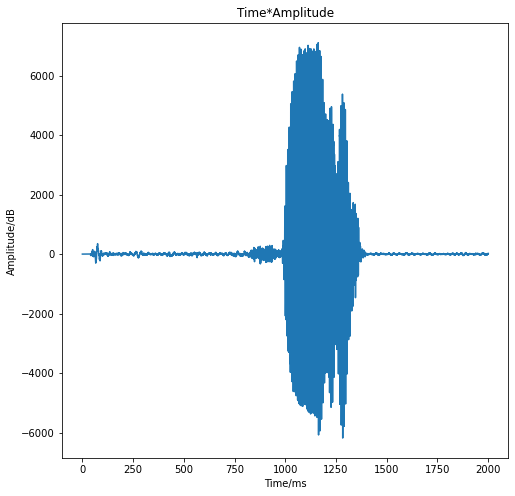

In [649]:
pam.plot_wave(sr, wave_arr)

In [650]:
class AudioProcess:
    def __init__(self):
        pass
    
    # frame_size / ms
    def split_into_frames(self, sr, wave_arr, frame_size, overlap_ratio=0.5):
        N = int(sr/1000*frame_size)
        M = int(overlap_ratio*N)
        frame_count =int(wave_arr.shape[0]/(N-M))
        frames = [[i*(N-M), min((i+1)*(N-M)+M, wave_arr.shape[0])] for i in range(frame_count)]
        return frames
    
    # RECT, HANMMING, HANN
    def window_fn(self, N, WINDOW_FUNCTION="HANMMING"):
        if WINDOW_FUNCTION == "RECT":
            return np.array([1 for n in range(N)])
        elif WINDOW_FUNCTION == "HANMMING":
            return np.array([0.54-0.46*np.cos(2*np.pi*n/(N-1)) for n in range(N)])
        elif WINDOW_FUNCTION == "HANN":
            return np.array([0.5-0.5*np.cos(2*np.pi*n/(N-1)) for n in range(N)])
        else:
            return np.array([0.54-0.46*np.cos(2*np.pi*n/(N-1)) for n in range(N)])
        
    def add_window(self, wave_arr, frames, WINDOW_FUNCTION):
        # pre-emphasis
        tmp = np.zeros(wave_arr.shape[0]+1)
        tmp[1:] = wave_arr[:]
        tmp[0] = 0
        wave_arr = wave_arr[:] - 0.9375*tmp[:-1]
        
        windowed_wave_arr = np.zeros(wave_arr.shape[0])
        for frame in frames:
            windowed_wave_arr[frame[0]:frame[1]] = wave_arr[frame[0]:frame[1]]*self.window_fn(frame[1]-frame[0], WINDOW_FUNCTION)
        return windowed_wave_arr
    
    # short-time average energy
    def compute_energy(self, wave_arr, frames):
        energy = []
        for frame in frames:
            energy.append((wave_arr[frame[0]:frame[1]]*wave_arr[frame[0]:frame[1]]).sum())
        return energy
    
    # short-time zero-cross rate
    def compute_zcr(self, wave_arr, frames):
        zcr = []
        tmp = np.zeros(wave_arr.shape[0]+1)
        tmp[1:] = wave_arr[:]
        tmp[0] = 0
        for frame in frames:
            zcr.append((np.abs(np.sign(wave_arr[frame[0]:frame[1]])-np.sign(tmp[frame[0]:frame[1]]))).sum()/2)
        return zcr
    
    def end_point_detection(self, energy, zcr):
        max_energy = max(energy)
        max_zcr = max(zcr)
        high_energy_threshold = max_energy * 1/2500
        low_energy_threshold = max_energy * 1/5000
        zcr_threshold = max_zcr * 1/2
        max_energy_idx = energy.index(max_energy)
        max_zcr_idx = zcr.index(max_zcr)
        
        l, r = 0, len(energy)-1
        
        for i in range(max_energy_idx, -1, -1):
            if energy[i] < high_energy_threshold:
                l = i
                break
        for i in range(max_energy_idx, len(energy)):
            if energy[i] < high_energy_threshold:
                r = i
                break
        
        for i in range(l, -1, -1):
            if energy[i] < high_energy_threshold:
                l = i
                break
        for i in range(r, len(energy)):
            if energy[i] < high_energy_threshold:
                r = i
                break
                
        for i in range(l, -1, -1):
            if zcr[i] < zcr_threshold:
                l = i
                break
        for i in range(r, len(energy)):
            if zcr[i] < zcr_threshold:
                r = i
                break
        return l, r
    
    def extract_time_domain_features(self, sr, wave_arr, ):
        

In [651]:
WINDOW_FUNCTION = "HANMMING"
ap = AudioProcess()
frames = ap.split_into_frames(sr, wave_arr, 10, 0.4)
windowed_wave_arr = ap.add_window(wave_arr, frames, WINDOW_FUNCTION)

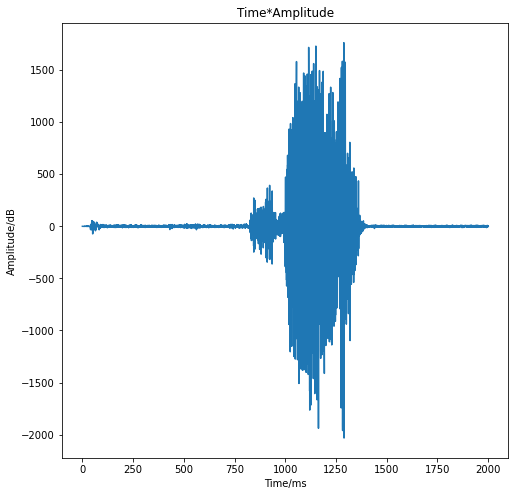

In [652]:
pam.plot_wave(sr, windowed_wave_arr)

In [653]:
energy = ap.compute_energy(windowed_wave_arr, frames)
zcr = ap.compute_zcr(windowed_wave_arr, frames)

Text(0, 0.5, 'Amplitude')

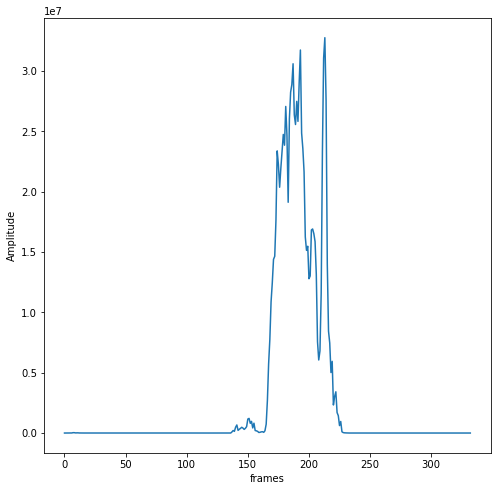

In [654]:
plt.figure(figsize=(8, 8))
plt.plot(energy)
plt.xlabel('frames')
plt.ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

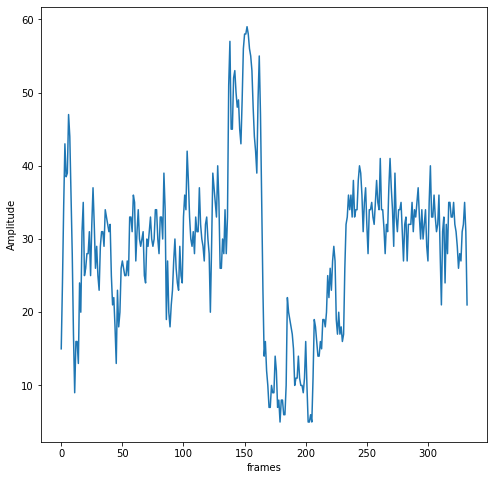

In [655]:
plt.figure(figsize=(8, 8))
plt.plot(zcr)
plt.xlabel('frames')
plt.ylabel('Amplitude')

In [656]:
start_point, end_point = ap.end_point_detection(energy, zcr)
start_point, end_point

(135, 231)